# Why use causal graphs?

We have all been told that it is impossible to infer causality from observational data. Strictly speaking, this is true. However, we live in a world where people make these kinds of inferences all the time. We have to. Randomized experiments are not always possible or ethical, but causal information about the world hugely important to medicine, economics, and other fields.

The conventional wisdom that "correlation does not imply causation" is true but useless, and in fact, it can lead to serious problems. Unable to use formal tools, decision makers will often rely on ad hoc judgements of which associations can be credibly interpreted as causal effects, implicitly making assumptions about the causal structure of the data. This is problematic because it is only when these assumptions are made explicit that they can be tested and critiqued. Small variations in assumptions about causal structure can lead to surprisingly large differences in the outcome of an analysis, making it especially important to be explicit about these kinds of assumptions.

A better framing is "no causality in, no causality out". Causal graphs are a way to make assumptions about the causal structure of the data explicit, and to use these assumptions to draw quantitative conclusions about causal effects sizes. In other words, although it's not possible to *infer* causal relationships, it is often possible to *measure* them if you assume that they exist. Causal graphs enable this measurement.

Causal graphs are not a silver bullet. They cannot tell you what causal assumptions to make. But, they provide a useful interface to these kinds of assumptions, allowing for faster iteration on these assumption and enabling collaboration between data scientists, domain experts, and computational tools.

The following experiment shows how failure to correctly identify the correct causal structure, or attempts to push this problem under the mat, can cause serious errors in an analysis. Meanwhile, true knowledge, even partial, about the structure can be used to make correct inferences about causal effects.

## Simulating the Data

We will use `pqp` for this experiment. `pqp` is a Python package for causal inference that I am developing. It is still in the early stages, but it is already useful for some applications. It is available on PyPi.

In [1]:
from pqp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

The simulated dataset will have four variables---$x$, $y$, $z$, and $m$---each represeting a binary random variable. We are interested in measuring the effect of $x$ on $y$ in the case where $z$ is not observed. The true causal graph, representing the data generating process, is shown below. Arrows represent causal relationships, where changing one variable will exert a direct effect on another.

An easy way to interpret this is to imagine that we are studying a new, experimental medical procedure. Each row represents a patient with a given condition.

- $x$, the *treatment variables*, represents whether or not the patient received the procedure.
- $y$, the *outcome variable*, represents whether they recovered.
- $z$, a *confounder*, which influences both whether the procedure was administered and whether they recovered. This might be something like the severity of the patient's condition--worse cases where more likely to receive treatment.
- $m$, a *mediator*, lies along the causal pathway from $x$ to $y$. This is a mechanism by which the treatment affects the outcome. In this case, it might be something like the patient's blood pressure, which is reduced by the by the procedure and makes a positiver outcome more likely.

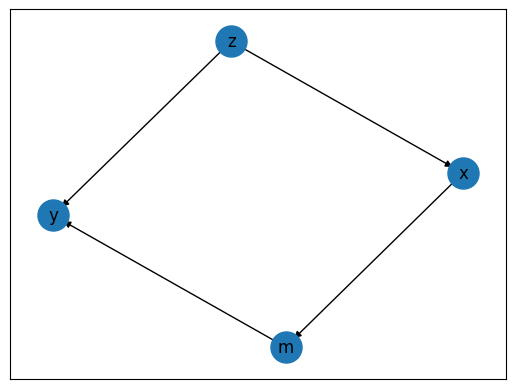

In [2]:
x, y, z, m = make_vars("xyzm")

true_graph = Graph([
    x <= z,
    m <= x,
    y <= [z, m]
])

true_graph.draw()


We define the size of the direct effects in the next cell. 

In [3]:
true_direct_effect = {
    (z, x): 0.5,  # severity makes treatment 50% more likely
    (x, m): 0.5,  # treatment reduces blood pressure 50% of the time
    (m, y): 0.5,  # reduced blood pressure increases the odds of recovery 50% of the time
    (z, y): -0.25  # recovery is 25% less likely in severe cases
}

Next, we simulate the actual data. The simulation is setup so that each variable has an expected value of $0.5$ for the sake of simplicity.

In [4]:
# number of data points
n = 10000

df = pd.DataFrame()
df["z"] = (np.random.uniform(0, 1, n) > 0.5).astype(int)
df["x"] = (np.random.uniform(0, 1, n) + df["z"] * true_direct_effect[(z, x)] > 0.5 * (1 + true_direct_effect[(z, x)])).astype(int)
df["m"] = (np.random.uniform(0, 1, n) + df["x"] * true_direct_effect[(x, m)] > 0.5 * (1 + true_direct_effect[(x, m)])).astype(int)
df["y"] = (np.random.uniform(0, 1, n) + true_direct_effect[(m, y)] * df["m"] + true_direct_effect[(z, y)] * df["z"] > 0.5 * (1 + true_direct_effect[(m, y)] + true_direct_effect[(z, y)])).astype(int)

df.head()

,z,x,m,y
0,0,1,1,1
1,0,0,0,0
2,0,0,0,0
3,1,1,1,1
4,0,0,0,1


## Formal Problem Statement

There are a lot of different ways to operationalize the concept of a causal effect. Here, we'll be using the $ATE$ or average treatment effect. This is the expected difference in outcome that would result from treatment of a random unit from the sample. In other words, if we picked a random patient from the sample and gave them the treatment, how much more likely are they to recover than if they didn't receive the treatment.

This is *not* equivalent to the difference in expected outcomes between the treatment and control group as the units in these two groups are drawn from different distributions. In our example, patients with severe cases were more likely to receive treatment.

There is a lot of nuance here that I won't cover, but the key point is that the ATE is a well-defined quantity that mostly captures what we mean when we talk about the effect of a treatment.

In [5]:
causal_estimand = ATE(
    y,          # outcome variable
    {x: 1},     # definition of treatment
    {x: 0}      # definition of control
)
causal_estimand.display()

<IPython.core.display.Math object>

Next, we fit the data with a categorical distribution. It's necessary to fit a model to the data to answer any interesting questions about. Typically, this will be a parametric model such as a logistic regression model. However, because our data is fairly low-dimensional, we can use a nonparametric model here, the categorical distribution with maximum likelihood estimation. This model comes from `pqp` .

In [6]:
data = Data(df)
estimator = MultinomialEstimator(data, prior=1)
estimator

MultinomialEstimator(observed=[x, m, z, y])

# Analytical Solution

Since the data is simulated, we know the true generating process for the data, and so we can analytically calculate the true ATE. This is the correct answer that we will try to recover using different techniques.

The calculation looks a little bit complicated, but all we are doing is using our knowledge that the effects in the model are all linear. This means that the total effect of $x$ on $y$ is just the sum of the effects along each directed path from $x$ to $y$. To figure out the effect along each path, we simply multiple the direct effect associated with each edge. If you didn't follow that, don't worry. The key point is that we can calculate the true ATE analytically.

In [8]:
analytical_effects = {}

v = [z, x, m, y]
for i in range(4):
    for j in range(i + 1, 4):
        start = v[i]
        end = v[j]

        for path in true_graph.dfs(start, end):
            path = list(path)
            path_value = 1
            for edge in zip(path[:-1], path[1:]):
                edge_value = true_direct_effect.get(edge, 0)
                path_value *= edge_value
            analytical_effects[(start, end)] = analytical_effects.get((start, end), 0) + path_value

print("Analytical Values\n")
for (start, end), value in analytical_effects.items():
    print(f"ATE(treatment={start}, outcome={end}) = {value}")


Analytical Values

ATE(treatment=z, outcome=x) = 0.5
ATE(treatment=z, outcome=m) = 0.25
ATE(treatment=z, outcome=y) = -0.125
ATE(treatment=x, outcome=m) = 0.5
ATE(treatment=x, outcome=y) = 0.25
ATE(treatment=m, outcome=y) = 0.5


We can see that the true average treatment effect of $x$ on $y$ is $0.25$. We can get the same result empirically using `pqp`.

In [9]:
est = true_graph.identify(causal_estimand)
est.identified_estimand.display()
estimator.estimate(est)

<IPython.core.display.Math object>

EstimationResult(value=0.2460116520134078)

With perfect information, getting the right answer is easy. However, recall that in our scenario, we are trying to estimate the effect of $x$ on $y$ when $z$ is not observed. Next, we will look at a number of approaches to this problem.

## Overcontrolling

First, we can look at estimating the effect under the assumption that $x$ has a direct effect on $y$, and there are no confounders or mediators. We represent this model using a graph.

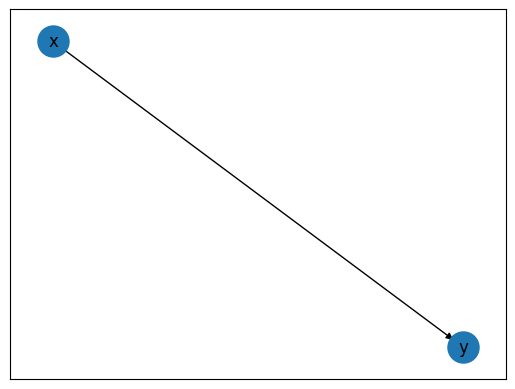

In [10]:
naive_graph = Graph([y <= x])
naive_graph.draw()

We then use this graph to identify the $ATE$ and estimate it.

In [11]:
est = naive_graph.identify(causal_estimand)
est.identified_estimand.display()
estimator.estimate(est)

<IPython.core.display.Math object>

EstimationResult(value=0.12778469382701846)

As we can see, `pqp` has determined that under this set of causal assumptions, the $ATE$ is equivalent to the difference in expected outcomes between the treatment and control groups. This method significantly underestimates the size of the effect, at ~$0.13$. This is because of difference is the underlying distribution from which treatment and control units are drawn (aka confounding). More severe cases were more likely to receive treatment and less likely to recover.

So, if we attempt to estimate the effect without any knowledge of the causal structure and without any covariates, we will get the wrong answer. We have access to another variable though, $m$. Suppose we control for this variable in our analysis. Will this be any closer?

We can represent this strategy using a graph. We are controlling for $m$ here, which means treating it as a confounder.

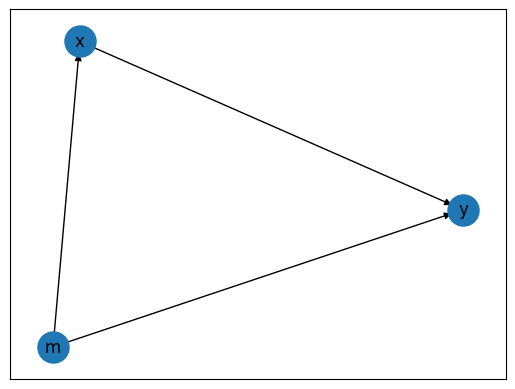

In [12]:
control_graph = Graph([
    x <= m,
    y <= [x, m]
])
control_graph.draw()

We can then identify and estimate the effect.

In [13]:
est = control_graph.identify(causal_estimand)
est.identified_estimand.display()
estimator.estimate(est)

<IPython.core.display.Math object>

EstimationResult(value=-0.1270725342061666)

The results are even worse! Now the estimator isn't only wrong, it has flipped the sign on the effect. This is because $m$ is a mediator, and controlling for it has blocked the causal pathway from $x$ to $y$, eliminating the causal effect. Now, the *only* remaining nonrandom association between $x$ and $y$ is the difference in the underlying treatment and control populations. As we saw above, this difference incorrectly suggests that the treatment was actually detrimental.

There is an important lesson here: mindlessly controlling for variables will not help to uncover the causal effect. Unfortunately, this is an appraoch adopted by a large portion of the existing academic corpus on many subjects.

Another example will illustrate this further. In our scenario, we don't have access to $z$, but suppose we did. But, instead of accurately modeling the underlying causal structure, we chose to simply control for both $m$ and $z$.

In [14]:
control_graph_z_observed = Graph([
    x <= [z, m],
    y <= [x, m, z]
])
est = control_graph_z_observed.identify(causal_estimand)
est.identified_estimand.display()
estimator.estimate(est)

<IPython.core.display.Math object>

EstimationResult(value=-0.010405142334699136)

The value is close to zero. We can controlled for the only two pathways by which $x$ and $y$ were associated, and now the only remaining association is due to noise. Don't mindlessly control for variables! It will not help you.

## Success Using Causal Graphs

Now, we will show how the correct effect size can be recovered from the data even if $z$ is unobserved. We will model $m$ as a mediator, and we will note the presence of a possible unobserved confounder between $x$ and $y$. This is represented by a dashed line in the graph.

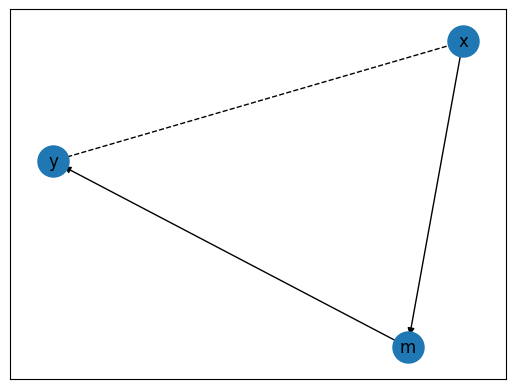

In [16]:
smart_graph = Graph([
    m <= x,
    y <= m,
    y & x
    ])
smart_graph.draw()

In [17]:
est = smart_graph.identify(causal_estimand)
est.identified_estimand.display()
estimator.estimate(est)

<IPython.core.display.Math object>

EstimationResult(value=0.2548263847173535)

We recover the correct answer of $0.25$. The identification routine in `pqp` is able to route around the unobserved confounder by using the mediator $m$, although we can see how this adds complexity to the estimator.

## An Insufficient Graph

We have seen how making the wrong assumptions about the causal structure can lead to incorrect estimates. So, what if we make as few assumptions as possible? As a final illustration, we can examing this approach. We think there is a causal effect from $x$ to $y$, but we can indicate that we don't know anything else about the causal structure by adding additional edges to represent possible confounding.

In [19]:
underdetermined_graph = Graph([
    y <= x,
    x & y,
])
underdetermined_graph.identify(causal_estimand)

IdentificationResult(identified_estimand=E_(y) [ FAIL ] - E_(y) [ FAIL ])

The identification routine returns `FAIL`. There is not enough information to measure the effect because any association between $x$ and $y$ could be due to either the direct effect or confounding. You do need make assumptions in causal inference.

## Conclusion

Drawing causal conclusions from observational data must be done with care. Incorrect assumptions can very quickly derail an analysis, and the only solution is to be careful about the assumptions you make. Hopefully, you will find causal graphs a useful tool for making these assumptions explicit.